In [1]:
import json
import polars as pl
import torch
from tqdm import tqdm
import random
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

seed_val = 0
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

torch.manual_seed(seed_val)
random.seed(seed_val)
np.random.seed(seed_val)

In [2]:
with open("./params.json", mode = "r", encoding = "utf-8") as f:
    data = json.load(f)
    model_path = data["model_path"]
    num_single_sample_timesteps = data["num_single_sample_timesteps"]
    input_window_length = data["input_window_length"]
    input_features = data["input_features"]
    label_features = data["label_features"]

In [3]:
class PositionalEncoding(torch.nn.Module):
    def __init__(self, d_model, dropout, max_len):
        super().__init__()
        self.dropout = torch.nn.Dropout(dropout)
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype = torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-torch.log(torch.tensor(10000.0)) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        self.register_buffer("pe", pe.unsqueeze(0))

    def forward(self, x):
        x = x + self.pe[:, :x.size(1), :]
        return self.dropout(x)

In [4]:
class TimeSeriesTransformer(torch.nn.Module):
    def __init__(self, input_dim, output_dim, d_model, num_head, num_encoder_layers, num_decoder_layers, positional_encoding_max_len, position_wise_ffn_dim, dropout):
        super().__init__()
        self.input_proj = torch.nn.Linear(input_dim, d_model)
        self.output_proj = torch.nn.Linear(output_dim, d_model)
        
        self.pos_encoder = PositionalEncoding(
            d_model = d_model,
            dropout = dropout,
            max_len = positional_encoding_max_len
        )

        self.transformer = torch.nn.Transformer(
            d_model = d_model,
            nhead = num_head,
            num_encoder_layers = num_encoder_layers,
            num_decoder_layers = num_decoder_layers,
            dropout = dropout,
            dim_feedforward = position_wise_ffn_dim,
            batch_first = True
        )

        self.final_proj = torch.nn.Linear(d_model, output_dim)

        # Multi-head Self-Attention
        self.attention_weights = {
            "encoder_attention": [],
            "decoder_attention": [],
            "encoder_decoder_attention": []
        }
        self._register_attention_hooks()

    def _register_attention_hooks(self):
        self.attention_weights = {
            "encoder_attention": [],
            "decoder_attention": [],
            "encoder_decoder_attention": []
        }

        # They are all multi-head self-attentions --> The naming convention is different
        for layer in self.transformer.encoder.layers:
            self._patch_multi_head_attetion(layer.self_attn, "encoder_attention")

        for layer in self.transformer.decoder.layers:
            self._patch_multi_head_attetion(layer.self_attn, "decoder_attention")
            self._patch_multi_head_attetion(layer.multihead_attn, "encoder_decoder_attention")

    def _patch_multi_head_attetion(self, mha_module, attn_type):
        '''
            We have a saved transformer model that did not have the attention tracking
            The goal here is to patch the forward method in the trained transformer model so that it proceeds normally but also tracks attentions.
            That's why we are assigning a function to the forward method 
        '''
        original_forward = mha_module.forward

        def new_forward(*args, **kwargs):
            # Two lines combined together will return each attention head not averaged across all heads!
            kwargs["need_weights"] = True
            kwargs["average_attn_weights"] = False

            attn_output, attn_output_weights = original_forward(*args, **kwargs)
            self.attention_weights[attn_type].append(attn_output_weights)

            return attn_output, attn_output_weights

        # Replace the forward method with our patched version
        mha_module.forward = new_forward

    def forward(self, src, tgt, tgt_mask = None):
        for key in self.attention_weights.keys():
            self.attention_weights[key].clear()

        src = self.input_proj(src)
        src = self.pos_encoder(src)
        
        tgt = self.output_proj(tgt)
        tgt = self.pos_encoder(tgt)
        
        if(tgt_mask is None):
            tgt_mask = self.transformer.generate_square_subsequent_mask(tgt.size(1)).to(tgt.device)

        decoder_out = self.transformer(src, tgt, tgt_mask = tgt_mask)

        return self.final_proj(decoder_out)

In [5]:
df = pl.read_csv("./reversalData_minor.csv")
df = df.drop(["id", "eps", "n_0_squared"])
df = df.select(
    pl.col("*").str.json_decode()
)
df = df.with_columns(
    eta_list = pl.col("eta_list").list.eval(pl.element().flatten(), parallel = True)
)
df = df.sample(n = len(df), with_replacement = False, shuffle = True, seed = seed_val)

In [6]:
df_test = df[int(len(df) * 0.9):]
df_test = df_test.select(
    (pl.col("*") - pl.col("*").list.mean()) / pl.col("*").list.std()
)

In [7]:
def createPredictionWindows(dataframe, stride, input_features, input_window_length, label_features):
    """
        Creates predictions windows where input_window moves by stride and the label window is the all remaining timesteps

        dataframe: In time-series format where columns are features and rows are time-series steps (Polars exploded format!)
        stride: How many timesteps will input_window move by.
        input_features: Names of the input features in a list
        input_window_length: Input window size in timesteps
        label_features: Names of the label features in a list
    """

    input_df = dataframe.select(
        pl.col(input_features)
    )
    input_df = input_df.select(
        numbers = pl.concat_list("*")   # List of all features
    )
    input_df = input_df[:-1].with_row_index("index").with_columns(    # Exluding last timestep which will be min label window length
        pl.col("index").cast(pl.Int64)
    )
    input_df = input_df.group_by_dynamic(   # index is considered for grouping
        index_column = "index",
        period = f"{input_window_length}i",
        every = f"{stride}i",
        closed = "left"
    ).agg(
        pl.col("numbers").alias("X"),
        pl.len().alias("seq_len")
    )
    input_df = input_df.filter(
        pl.col("seq_len") == input_window_length
    )
    input_df = input_df.select(
        pl.exclude(["index", "seq_len"])
    )


    label_df = dataframe.select(
        pl.col(label_features)
    )
    label_df = label_df.select(
        numbers = pl.concat_list("*")
    )
    label_df = label_df[input_window_length:].with_row_index("index").with_columns(
        pl.col("index").cast(pl.Int64)
    )
    label_df = label_df.group_by_dynamic(
        index_column = "index",
        period = f"{num_single_sample_timesteps - input_window_length}i",
        every = f"{stride}i",
        closed = "left"
    ).agg(
        pl.col("numbers").alias("Y")    # Removing the seq_len check will handle our goal!
    )
    label_df = label_df.select(
        pl.exclude(["index"])
    )

    return pl.concat([input_df, label_df], how = "horizontal")    

In [8]:
df_test = df_test.explode("*")

timeseries_df_test = pl.DataFrame()

for i in range(0, len(df_test), num_single_sample_timesteps):
    temp_df = createPredictionWindows(
        dataframe = df_test[i:i + num_single_sample_timesteps],
        stride = 1,
        input_features = input_features,
        input_window_length = input_window_length,
        label_features = label_features
    )

    if(temp_df.is_empty()):
        timeseries_df_test = temp_df
    else:
        timeseries_df_test = pl.concat([timeseries_df_test, temp_df], how = "vertical")

timeseries_df_test

X,Y
list[list[f64]],list[list[f64]]
"[[0.143977, -0.613181, … -1.168601], [0.140459, -0.652986, … -0.109782], … [-0.22139, 1.900679, … 0.775233]]","[[0.399958, 0.305306], [0.408099, 0.313849], … [-0.803586, 2.445361]]"
"[[0.140459, -0.652986, … -0.109782], [-0.205712, -0.657308, … -1.495147], … [0.331293, 1.870861, … 0.130115]]","[[0.408099, 0.313849], [0.426035, 0.740275], … [-0.803586, 2.445361]]"
"[[-0.205712, -0.657308, … -1.495147], [-0.220805, -0.652731, … -0.010263], … [0.322671, 1.791194, … -1.268209]]","[[0.426035, 0.740275], [0.455748, 1.045916], … [-0.803586, 2.445361]]"
"[[-0.220805, -0.652731, … -0.010263], [-0.411076, -0.61671, … 1.260905], … [0.794697, 1.667755, … -2.717769]]","[[0.455748, 1.045916], [0.495336, 1.406211], … [-0.803586, 2.445361]]"
"[[-0.411076, -0.61671, … 1.260905], [-0.572723, -0.555823, … 0.413349], … [1.082893, 1.486055, … -2.828508]]","[[0.495336, 1.406211], [0.54421, 1.616953], … [-0.803586, 2.445361]]"
…,…
"[[1.789584, -0.709353, … 0.067224], [1.587199, -1.03347, … 0.0692], … [0.603935, 0.818797, … 1.015267]]","[[-1.605575, 1.638573], [-1.536435, 1.965371], … [-1.225562, 3.178628]]"
"[[1.587199, -1.03347, … 0.0692], [1.149834, -1.292198, … -0.828293], … [0.668201, 0.738234, … 0.220167]]","[[-1.536435, 1.965371], [-1.453969, 2.790816], … [-1.225562, 3.178628]]"
"[[1.149834, -1.292198, … -0.828293], [1.030136, -1.490667, … 0.769778], … [0.80388, 0.623234, … -0.451152]]","[[-1.453969, 2.790816], [-1.342817, 3.029262], [-1.225562, 3.178628]]"


In [9]:
df_test = timeseries_df_test

%reset_selective -f "^timeseries_df_test$"
%reset_selective -f "^df$"

## Prediction

In [10]:
model = torch.load(model_path, weights_only = False).to(device)
model._register_attention_hooks()
model.eval()

TimeSeriesTransformer(
  (input_proj): Linear(in_features=14, out_features=32, bias=True)
  (output_proj): Linear(in_features=2, out_features=32, bias=True)
  (pos_encoder): PositionalEncoding(
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (transformer): Transformer(
    (encoder): TransformerEncoder(
      (layers): ModuleList(
        (0-1): 2 x TransformerEncoderLayer(
          (self_attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=32, out_features=32, bias=True)
          )
          (linear1): Linear(in_features=32, out_features=16, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
          (linear2): Linear(in_features=16, out_features=32, bias=True)
          (norm1): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
          (norm2): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
          (dropout1): Dropout(p=0.1, inplace=False)
          (dropout2): Dropout(p=0.1, inplace=False)
        )
      )
    

  0%|          | 0/1000 [00:01<?, ?it/s, single_test_loss=2.521995]

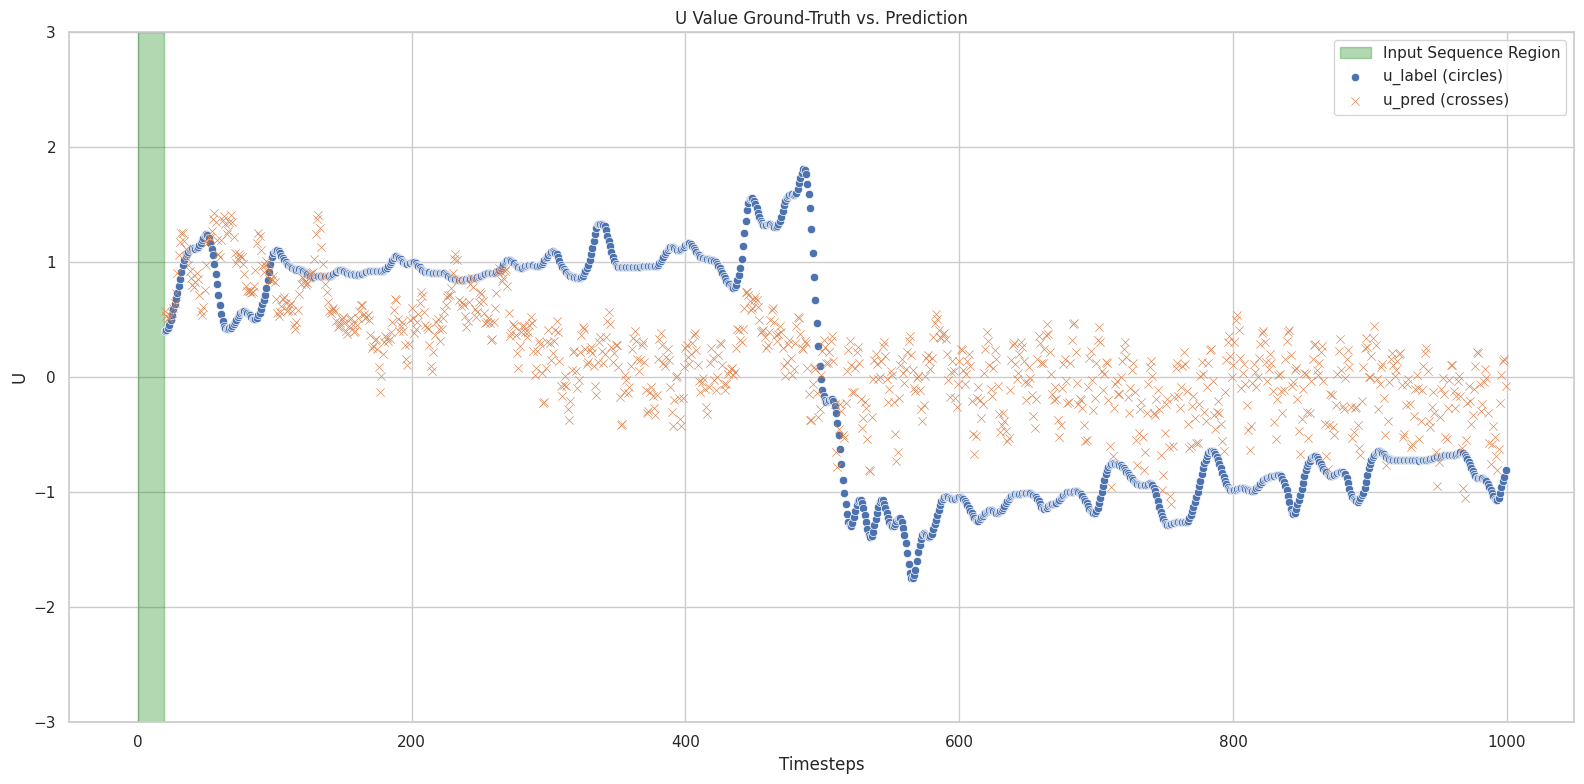

  0%|          | 1/1000 [00:01<32:21,  1.94s/it, single_test_loss=2.521995]

Output Timestep 21: Input Timesteps [20 19 18 17 16 15 14  1 13  2] with scores ['0.08297', '0.07662', '0.07032', '0.06307', '0.05682', '0.05112', '0.04753', '0.04578', '0.04570', '0.04488']
Output Timestep 22: Input Timesteps [20 19 18 17  1  2 16  3  5  6] with scores ['0.08224', '0.07844', '0.07577', '0.06425', '0.05527', '0.05190', '0.04955', '0.04876', '0.04755', '0.04710']
Output Timestep 23: Input Timesteps [20 19  1 18  2  3 17  4  5  6] with scores ['0.08262', '0.07687', '0.07256', '0.07176', '0.06794', '0.05865', '0.05705', '0.05170', '0.04925', '0.04821']
Output Timestep 24: Input Timesteps [20  1  2 19 18  3  4  5 17  6] with scores ['0.11074', '0.09622', '0.08966', '0.08833', '0.07153', '0.07001', '0.05569', '0.04733', '0.04532', '0.04413']
Output Timestep 25: Input Timesteps [20  1  2 19  3 18  4  5 17  6] with scores ['0.14291', '0.10814', '0.10045', '0.09985', '0.07431', '0.07216', '0.05549', '0.04296', '0.03943', '0.03806']
Output Timestep 26: Input Timesteps [20  1 19

  2%|▏         | 20/1000 [00:47<46:14,  2.83s/it, single_test_loss=3.389647]

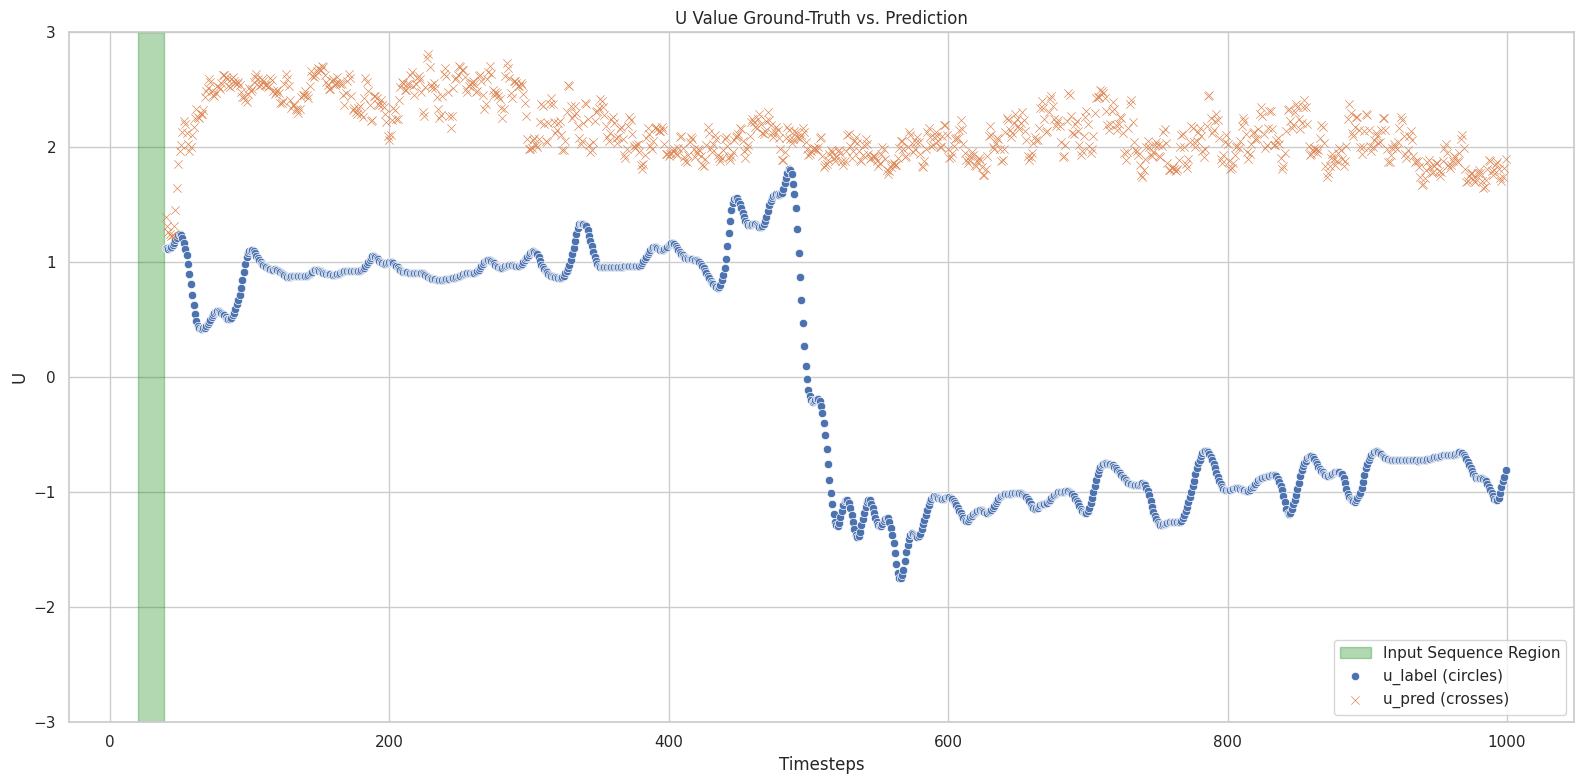

  2%|▏         | 21/1000 [00:47<49:26,  3.03s/it, single_test_loss=3.389647]

Output Timestep 41: Input Timesteps [40 39 38 37 21 22 23 24 36 25] with scores ['0.08899', '0.07808', '0.06870', '0.06168', '0.05847', '0.05800', '0.05576', '0.05374', '0.05321', '0.05000']
Output Timestep 42: Input Timesteps [40 39 38 37 36 28 29 21 22 27] with scores ['0.11851', '0.10591', '0.09292', '0.07255', '0.05058', '0.04764', '0.04535', '0.04333', '0.04250', '0.04179']
Output Timestep 43: Input Timesteps [40 39 38 37 21 36 22 23 28 24] with scores ['0.13112', '0.11771', '0.10280', '0.07646', '0.05075', '0.05035', '0.04924', '0.04407', '0.04040', '0.03976']
Output Timestep 44: Input Timesteps [40 39 38 37 21 22 23 36 24 25] with scores ['0.17020', '0.13599', '0.10598', '0.06945', '0.06208', '0.05912', '0.04952', '0.04199', '0.04101', '0.03456']
Output Timestep 45: Input Timesteps [40 39 38 21 22 37 23 24 36 25] with scores ['0.20173', '0.14177', '0.09979', '0.07105', '0.06645', '0.06049', '0.05367', '0.04233', '0.03650', '0.03300']
Output Timestep 46: Input Timesteps [40 39 38

  4%|▎         | 36/1000 [01:21<41:31,  2.58s/it, single_test_loss=8.575499]

In [ ]:
test_loss = 0.0
test_progress_bar = tqdm(
    range(num_single_sample_timesteps)
)

criterion = torch.nn.MSELoss()
plot_counter = 0

with torch.no_grad():
    for i in test_progress_bar:
        batch_x = torch.Tensor(df_test[i, "X"]).unsqueeze(0).to(device)
        batch_y = torch.Tensor(df_test[i, "Y"]).unsqueeze(0).to(device)
        outputs = []
        decoder_input = torch.zeros(batch_y.shape[0], 1, len(label_features)).to(device)
        for t in range(batch_y.shape[1]):
            tgt_mask = model.transformer.generate_square_subsequent_mask(decoder_input.shape[1]).to(device)
            out = model(
                batch_x,
                decoder_input,
                tgt_mask = tgt_mask
            )
            next_step = out[:, -1:, :]
            outputs.append(next_step)
            decoder_input = torch.cat([decoder_input, next_step], dim = 1)

        pred = torch.cat(outputs, dim = 1)
        loss = criterion(pred, batch_y)
        test_progress_bar.set_postfix({
            "single_test_loss": f"{loss.item():.6f}"
        })

        if(plot_counter % input_window_length == 0):
            x = list(range(num_single_sample_timesteps))
            u_label = batch_y[:, :, 0].cpu()[0]
            u_pred = pred[:, :, 0].cpu()[0]

            sns.set_theme(style = "whitegrid")
            fig, ax = plt.subplots(figsize = (16, 8))
            ax.set_ylim(-3, 3)

            ax.axvspan(
                x[plot_counter],
                x[plot_counter + input_window_length - 1],
                color = "green",
                alpha = 0.3,
                label = "Input Sequence Region"
            )
            sns.scatterplot(
                x = x[(input_window_length + plot_counter):],
                y = u_label,
                marker = "o",
                label = "u_label (circles)",
                ax = ax
            )
            sns.scatterplot(
                x = x[(input_window_length + plot_counter):],
                y = u_pred,
                marker = "x",
                label = "u_pred (crosses)",
                ax = ax
            )

            ax.set_title("U Value Ground-Truth vs. Prediction")
            ax.set_xlabel("Timesteps")
            ax.set_ylabel("U")
            ax.legend()

            plt.tight_layout()
            plt.show()

            last_decoder_layer_shared_attention = model.attention_weights["encoder_decoder_attention"][-1][0]
            avg_attention_weights = last_decoder_layer_shared_attention.mean(dim = 0).cpu().numpy()

            for i in range(20):     # First 20 predictions following input sequence 
                output_row = avg_attention_weights[i, :]
                top_k_indices = np.argsort(output_row)[::-1][:10]    # Top 10 highest attention input timesteps
                top_k_scores = output_row[top_k_indices]
                print(f"Output Timestep {plot_counter + input_window_length + i + 1}: Input Timesteps {top_k_indices + plot_counter + 1} with scores {[f'{score:.5f}' for score in top_k_scores]}")


        plot_counter += 1